In [68]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk import trigrams
from nltk import bigrams
from collections import Counter
from typing import Dict, List, Optional, Union, cast

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report

import os
import time
import csv


import requests
import prepare

from sklearn.model_selection import train_test_split

#statistical testing
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Project Planning

The goal of this project is to use Natural Language Processing in order to build a predictive model of programming languages using the text from a users Github repository's readme.md. Planning for this project involved:

- Acquire data by webscraping Github to obtain enough text from repositories of *finish this sentence

- Create a readme.md, data dictionary, visualizations to accompany a formal presentation, and a Final Report Notebook.

- Clean and prepare the data for the first iteration through the data science pipeline, and automate these processes by storing as functions where applicable.

- Clearly define at least two hypotheses, set an alpha, run statistical tests as needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.

- Establish the baseline accuracy and document well.

- Train several classification models.

- Evaluate models on train and validate datasets.

- Document executive summary, conclusions, takeaways, and next steps in the Final Report Notebook.

- Upload readme.md, data dictionary, prepare.py, acquire.py, and Final Report Notebook.

# Executive Summary

- For this project our team chose to focus on the topic of mental health, and formed an initial hypothesis that due to the academic quantitative analysis of mental health, that certain languages, such as R, would be robust in the scrapped data.

- After some initial exploration of Github, we chose Python, Java, R, HTML, and JavaScript as the only languages of focus to build the predictive model. 

- The models used were a TFIDF and Count Vectorizer Logistic Regression and a TFIDF and Count Vectorizer Decision Tree model. The best performing model for this dataset was the Count Vectorized Decision Tree.

- The model did beat the baseline accuracy of 37%, and improving programming language prediction by 48%. 

- Although JavaScript was the most represented language in this dataset, certain words proved useful and unique to specific programming languages, additional study could prove useful in building a better predictive model in future iterations of this project.

![image_finished.png](image_finished.png)

# Acquire

- This data was obtained from Github repositories using those that appeared in the results after searching for mental health.

- Approximately 290 search results pages were scraped to obtain a robust dataset.

- The readme's from the repositories that fit our search criteria were added to our corpus.

In [69]:
df = prepare.wrangle_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1627 entries, 0 to 2142
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             1627 non-null   object
 1   language         1627 non-null   object
 2   readme_contents  1627 non-null   object
 3   stemmed          1627 non-null   object
 4   lemmatized       1627 non-null   object
 5   total_words      1627 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 89.0+ KB


# Prepare

- We scraped *insert how many* Github repositories

- In order to improve accuracy during the modeling process, this project focused on some of the top five programming languages that came up in the repository search mental health, which are:

    - Java
    - HTML
    - Python
    - R
    - JavaScript

# Explore

### Language Histograms/ Visualization?

<AxesSubplot:>

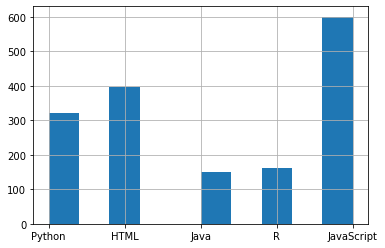

In [3]:
df.language.hist()

array([[<AxesSubplot:title={'center':'total_words'}>]], dtype=object)

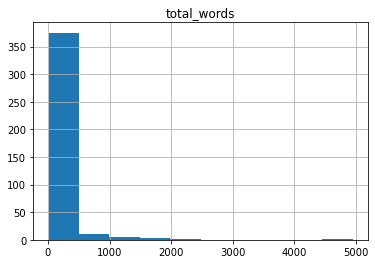

In [4]:
df.loc[df['language'] == 'HTML'].hist()

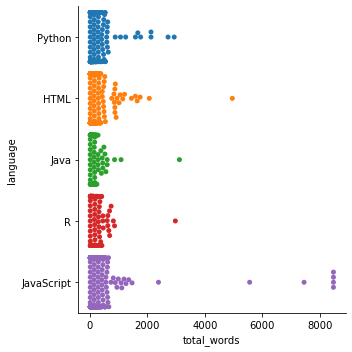

In [5]:
#plt.figure(fig_size = (10, 8))
sns.catplot(data = df,
           x = 'total_words',
           y = 'language',
           kind = 'swarm')

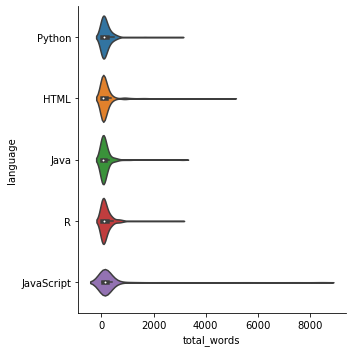

In [6]:
sns.catplot(data = df,
           x = 'total_words',
           y = 'language',
           kind = 'violin')

---

- Put this in a function

In [7]:
langs = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
langs.columns = ['counts', 'percent']
langs

#maybe show this as histograms or count plots

,counts,percent
JavaScript,600,0.368777
HTML,396,0.243393
Python,320,0.196681
R,162,0.099570
Java,149,0.091580


- Function?

In [8]:
ADDITIONAL = ['The', 'I', 'This', 'app', 'run', 'project', 'user', 'use', 'mental', 'file', 'health',
       'create', 'page', 'code', 'also', 'help', 'used']
             
def clean(readme_contents):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL
    text = (unicodedata.normalize('NFKD', readme_contents)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    #words = re.sub(r'[^a-z\s]', '', text).split()
    words = re.sub (r'([^a-zA-Z ]+?)', "", text).split()
    #words = re.sub(r'[\D]', '', words).split()
    
    
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


#making dfs with clean function for all langs
JavaScript_words = clean(' '.join(df[df.language == 'JavaScript'].readme_contents))
HTML_words = clean(' '.join(df[df.language == 'HTML'].readme_contents))
Python_words = clean(' '.join(df[df.language == 'Python'].readme_contents))
Java_words = clean(' '.join(df[df.language == 'Java'].readme_contents))
R_words = clean(' '.join(df[df.language == 'R'].readme_contents))
all_words = clean(' '.join(df.readme_contents))


#make dfs to show frequencies of words

JavaScript_freq = pd.Series(JavaScript_words).value_counts()
HTML_freq = pd.Series(HTML_words).value_counts()
Python_freq = pd.Series(Python_words).value_counts()
Java_freq = pd.Series(Java_words).value_counts()
R_freq = pd.Series(R_words).value_counts()
all_freq = pd.Series(all_words).value_counts()


word_counts = (pd.concat([all_freq, JavaScript_freq, HTML_freq, Python_freq, 
                    Java_freq, R_freq], axis=1, sort=True)
                .set_axis(['all_words', 'JavaScript', 'HTML', 'Python', 'Java', 'R'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all_words,JavaScript,HTML,Python,Java,R
aa,2,0,1,0,1,0
aaa,1,0,0,0,1,0
aaaa,3,0,0,1,0,2
aac,1,0,0,0,1,0
aachal,2,2,0,0,0,0


### Question 1: Do certain languages have a higher average readme word count than others?

In [9]:
#show averages with group by:
df.total_words.groupby(df.language).mean().round()

language
HTML          167.0
Java          140.0
JavaScript    245.0
Python        196.0
R             169.0
Name: total_words, dtype: float64

In [10]:
total_words = pd.DataFrame(df.total_words.groupby(df.language).mean().round())
total_words

,total_words
language,
HTML,167.0
Java,140.0
JavaScript,245.0
Python,196.0
R,169.0


In [11]:
#prep to make bins for the better visual
conditions = [(df.total_words > 171),
              (df.total_words >= 51) & (df.total_words <= 171),
              (df.total_words < 51)]
choices = ['high_count', 'med_count', 'low_count']

df['count_bin'] = np.select(conditions, choices)

In [12]:
df_plot = df.groupby(['language', 'count_bin']).size().reset_index().pivot(columns='count_bin', index='language', values=0)

<AxesSubplot:xlabel='language'>

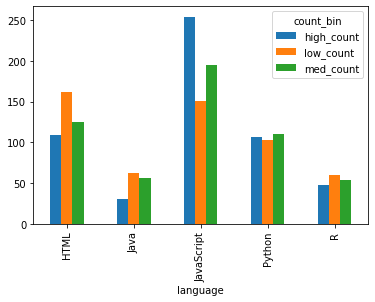

In [13]:
#I like this to show lang counts with bins

df_plot.plot(kind='bar')

#### Takeaways:

- There are certain languages that have a higher average readme word count than others.
- Java has the lowest average word count while those from repositories using JavaScript have considerably more words than the other four programming languages. 

### Are the word counts for JavaScript significantly higher than the mean word counts of all languages?

One Sample T-Test

$\alpha$ = .05

$𝐻_{0}$: JavaScript's mean word count is <= than the combined mean word count of all languages.

𝐻𝑎: JavaScript's mean word count is > than the combined mean word count of all programming languages.

In [14]:
α = 0.05

js_sample = word_counts.JavaScript

overall_mean = word_counts.all_words.mean()

t, p = stats.ttest_1samp(js_sample, overall_mean)

print(f'P Value: {p/2:.3f}')

if p/2 < α and t > 0:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis.')

P Value: 0.000
Fail to reject the null hypothesis.


---

### Are the word counts for JavaScript significantly higher than the word counts of Python?

Two Sample T-Test

$\alpha$ = .05

$𝐻_{0}$: Javascript's mean word count is <= than the mean word count of Python.

𝐻𝑎: Javascript's mean word count is > the mean word count of Python.

In [15]:
#test for equal variance 
#H0 is that the variances are equal
#Ha is that the variances are not equal
# if p > .05, variances are not significantly different and set argument to equal_var = True
#if p < .05, variances are significantly different and set argument to equal_var = False
#Levene test on two groups


#set alpha
α = 0.05

#perform test to determine variance
f, p = stats.levene(word_counts.JavaScript,
             word_counts.Python)

#evaluate coefficient and p-value
print(f'Levene\'s F-statistic: {f:.3f}\nP-value: {p:.3f}')


#evaluate if 
if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Levene's F-statistic: 285.039
P-value: 0.000
Reject the null hypothesis.


In [16]:
#set alpha
α = 0.05

#perform test
t, p = stats.ttest_ind(word_counts.JavaScript, word_counts.Python, equal_var = False)

#print p-value
print(f'P Value: {p/2:.3f}')

#evaluate if mean of the word counts associated w/ JavaScript is significantly higher than the mean 
# of the mean word counts associated with Python, is p/2 < a and t > 0?
if p/2 < α and t > 0:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

P Value: 0.000
Reject the null hypothesis.


---

### Are the word counts for R significantly lower than the word counts of Python?

Two Sample T-Test

$\alpha$ = .05

$𝐻_{0}$: R's mean word count is >= than the mean word count of Python.

𝐻𝑎: R's mean word count is < the mean word count of Python.

In [17]:
#test for equal variance 
#H0 is that the variances are equal
#Ha is that the variances are not equal
# if p > .05, variances are not significantly different and set argument to equal_var = True
#if p < .05, variances are significantly different and set argument to equal_var = False
#Levene test on two groups


#set alpha
α = 0.05

#perform test to determine variance
f, p = stats.levene(word_counts.R,
             word_counts.Python)

#evaluate coefficient and p-value
print(f'Levene\'s F-statistic: {f:.3f}\nP-value: {p:.3f}')


#evaluate if 
if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Levene's F-statistic: 267.514
P-value: 0.000
Reject the null hypothesis.


In [18]:
#set alpha
α = 0.05

#perform test
t, p = stats.ttest_ind(word_counts.R, word_counts.Python, equal_var = False)

#print p-value
print(f'P Value: {p/2:.3f}')

#evaluate if mean of the word counts associated w/ R is significantly lower than the mean 
# of the mean word counts associated with Python, is p/2 < a and t < 0?
if p/2 < α and t < 0:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

P Value: 0.000
Reject the null hypothesis.


#### QUESTION 2: Are certain frequently occurring words shared across more than one language?

In [19]:
#makes dfs for arranging top words by the diff langs to help compare
#if tops in some langs may be way different than tops in others
js_top = word_counts.sort_values(by='JavaScript', ascending=False).head(20)
html_top = word_counts.sort_values(by='HTML', ascending=False).head(20)
python_top = word_counts.sort_values(by='Python', ascending=False).head(20)
java_top = word_counts.sort_values(by='Java', ascending=False).head(20)
r_top = word_counts.sort_values(by='R', ascending=False).head(20)

In [20]:
#makes one df of the top 20 words in all dfs 
top_words = (pd.concat([js_top, html_top, python_top, java_top,
                    r_top], axis=0, sort=True)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

top_words.head()

,HTML,Java,JavaScript,Python,R,all_words
build,90,41,1268,54,22,1475
react,47,24,1209,22,0,1302
npm,93,33,1207,15,0,1348
section,219,8,843,42,18,1130
test,125,55,782,127,26,1115


In [21]:
#drops all as we don't need that to compare for next step
top_words= top_words.drop(columns=['all_words'])

### Graph this?

<AxesSubplot:>

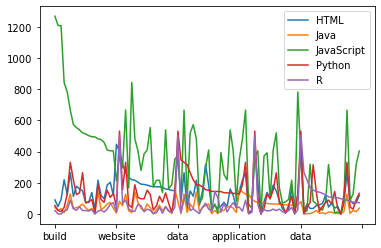

In [22]:
#if you want to graph somehow, but not super necessary to include this
top_words.plot()

In [24]:
#top_words

In [25]:
# sns.catplot(data = top_words,
#            x = top_words.index,
#            y = 'HTML')

In [26]:
#these are the frequent words that are shared amongst 2 or more programming languages
tops = top_words[top_words.index.value_counts() > 1]
tops.index.unique()

Index(['section', 'test', 'using', 'install', 'make', 'need', 'feature',
       'user', 'time', 'information', 'file', 'data', 'people', 'one',
       'application', 'model', 'analysis', 'dataset'],
      dtype='object')

#### Takeaways: 

- There are words that occur frequently and are shared across several languages.

- The following words are amongst the top 20 frequently occurring words (with the exception of stop words) in two or more languages:

'section', 'test', 'install', 'make', 'need', 'feature', 'user', 'time',
       'information', 'file', 'command', 'people', 'one', 'application',
       'model', 'dataset', 'analysis', 'following'

---

### QUESTION 3: What words, if any, are frequently occurring in readmes for certain languages that are barely prevalent in other language readmes?

In [27]:
#making the new df with top counts
most_freq = (word_counts[word_counts['all_words'] > 730])

In [28]:
#changing df to show percentages and transposing to visualize best

word_perc = pd.DataFrame()
for col in most_freq.columns:
    word_perc = word_perc.append(most_freq[col].sort_values(ascending=False)/most_freq[col].sum())

word_perc_T = word_perc.T
word_perc_T = word_perc_T
word_perc_T = word_perc_T.drop(columns=['all_words'])
#dropping the all column prior to graphing just bc it's not relevant to
#the question and don't want to cloud visual
word_perc_T

,JavaScript,HTML,Python,Java,R
data,0.030058,0.116667,0.174959,0.066007,0.440279
using,0.054398,0.077193,0.109061,0.104785,0.077594
build,0.103569,0.026316,0.017792,0.033828,0.019180
npm,0.098587,0.027193,0.004942,0.027228,0.000000
react,0.098750,0.013743,0.007249,0.019802,0.000000
section,0.068856,0.064035,0.013839,0.006601,0.015693
test,0.063873,0.036550,0.041845,0.045380,0.022668
user,0.039369,0.063158,0.061614,0.116337,0.014821
feature,0.042473,0.042982,0.086985,0.051980,0.018309
install,0.046802,0.033041,0.071829,0.029703,0.028771


Text(0.5, 1.0, 'Proportion of languages for the 20 most common words')

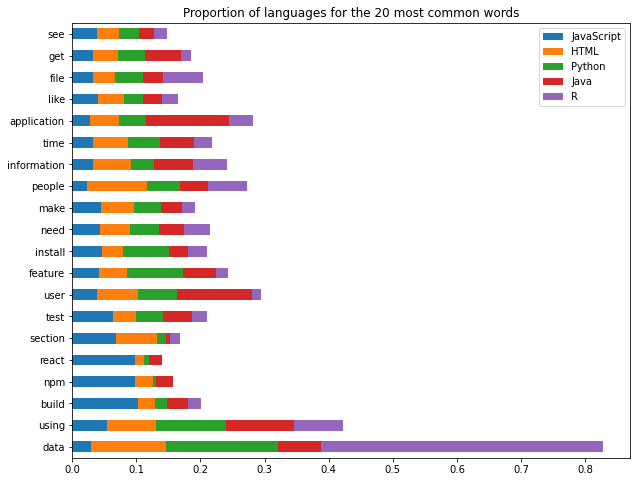

In [29]:
plt.rcParams["figure.figsize"] = (10,8)
word_perc_T.plot(kind = 'barh', stacked=True)

plt.title('Proportion of languages for the 20 most common words')

#### Takeaways: 

- There are words that frequently occur in some programming languages and are otherwise note prevalent in other programming languages. Certain words, like test, have a relatively similar distribution across languages while other words, like data, have a higher proportionality to languages like R and Python.

These top occurring words that may be helpful in identifying programming languages:

- 'data' : R
- 'file': R
- 'website': HTML
- 'application': Java
- 'react', 'build', 'npm': JavaScript

### Question 4: Can small groups of sequential words (bigrams and trigrams) in readmes be predictive of the target variable?

Text(0.5, 1.0, 'Proportion of languages for the 20 most common bigrams')

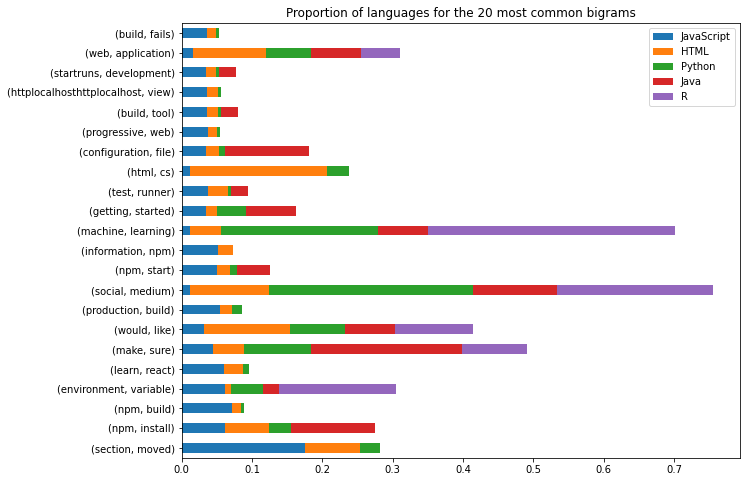

In [30]:
#this shows the 20 top most frequently occuring birgrams

bigrams_all = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts())
bigrams_JavaScript = (pd.Series(nltk.ngrams(JavaScript_words, 2))
                      .value_counts())
bigrams_HTML = (pd.Series(nltk.ngrams(HTML_words, 2))
                      .value_counts())
bigrams_Python = (pd.Series(nltk.ngrams(Python_words, 2))
                      .value_counts())
bigrams_Java = (pd.Series(nltk.ngrams(Java_words, 2))
                      .value_counts())
bigrams_R = (pd.Series(nltk.ngrams(R_words, 2))
                      .value_counts())

bigram_counts = (pd.concat([bigrams_all, bigrams_JavaScript, bigrams_HTML, bigrams_Python, 
                    bigrams_Java, bigrams_R], axis=1, sort=True)
                .set_axis(['all', 'JavaScript', 'HTML', 'Python', 'Java', 'R'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

most_freq_bigrams = (bigram_counts[bigram_counts['all'] >= 105])

word_perc_bigrams = pd.DataFrame()
for col in most_freq_bigrams.columns:
    word_perc_bigrams = word_perc_bigrams.append(most_freq_bigrams[col].sort_values(ascending=False)/most_freq_bigrams[col].sum())

word_perc_bigrams_T = word_perc_bigrams.T
word_perc_bigrams_T = word_perc_bigrams_T.drop(columns=['all'])
#dropping the all column prior to graphing just bc it's not relevant to
#the question and don't want to cloud visual

plt.rcParams["figure.figsize"] = (10,8)
word_perc_bigrams_T.plot(kind = 'barh', stacked=True)
plt.title('Proportion of languages for the 20 most common bigrams')

Text(0.5, 1.0, 'High Frequency Bigrams of Languages Compared')

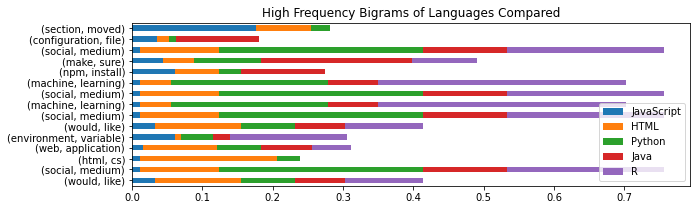

In [31]:
#This shows bigrams that have higher distribution (above 10%) in a certain languages
#this can be used to show what bigrams may be most predictive regardless of
#overall frequency
Java_high = word_perc_bigrams_T[word_perc_bigrams_T.Java > .1]
Python_high = word_perc_bigrams_T[word_perc_bigrams_T.Python > .1]
R_high = word_perc_bigrams_T[word_perc_bigrams_T.R > .1]
HTML_high = word_perc_bigrams_T[word_perc_bigrams_T.HTML > .1]
js_high = word_perc_bigrams_T[word_perc_bigrams_T.JavaScript > .1]

langs_high_tris = pd.concat([HTML_high, R_high, Python_high, Java_high, js_high])

plt.rcParams["figure.figsize"] = (10,3)
langs_high_tris.plot(kind = 'barh', stacked=True)
plt.title('High Frequency Bigrams of Languages Compared')

#### Bigram Takeaways: 
Here this graph shows the most useful bigrams, although many of the most identifiable bigrams are shared with two or more languages. 

Therefore, we will attempt to build on the notion of grouping words together for predictive potential and explore the value of trigrams.

---

Text(0.5, 1.0, 'High Frequency Trigrams of Languages Compared')

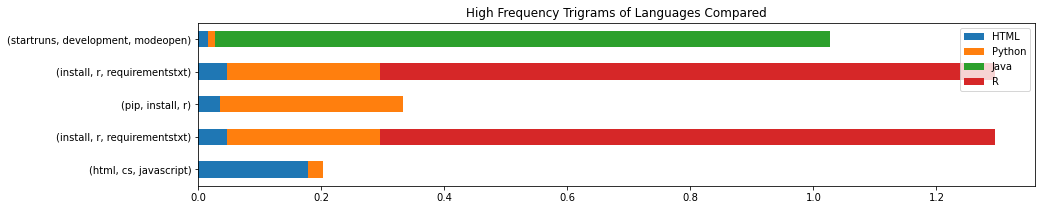

In [32]:
#This shows trigrams that have higher distribution (above 5%) in a certain languages
#this can be used to show what trigrams may be most predictive regardless of
#overall frequency
#note: high frequency trigrams are very evenly distributed across
#languages therefore the high frequency trigrams are not shown as there 
#is no potential predictivity there 

trigrams_all = (pd.Series(nltk.ngrams(all_words, 3))
                      .value_counts())
trigrams_JavaScript = (pd.Series(nltk.ngrams(JavaScript_words, 3))
                      .value_counts())
trigrams_HTML = (pd.Series(nltk.ngrams(HTML_words, 3))
                      .value_counts())
trigrams_Python = (pd.Series(nltk.ngrams(Python_words, 3))
                      .value_counts())
trigrams_Java = (pd.Series(nltk.ngrams(Java_words, 3))
                      .value_counts())
trigrams_R = (pd.Series(nltk.ngrams(R_words, 3))
                      .value_counts())

trigram_counts = (pd.concat([trigrams_all, trigrams_HTML, trigrams_Python, 
                    trigrams_Java, trigrams_R], axis=1, sort=True)
                .set_axis(['all', 'HTML', 'Python', 'Java', 'R'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

most_freq_trigrams = (trigram_counts[trigram_counts['all'] >= 30 ])
most_freq_trigrams = (most_freq_trigrams[most_freq_trigrams['all'] < 60])

word_perc_trigrams = pd.DataFrame()
for col in most_freq_trigrams.columns:
    word_perc_trigrams = word_perc_trigrams.append(most_freq_trigrams[col].sort_values(ascending=False)/most_freq_trigrams[col].sum())

word_perc_trigrams_T = word_perc_trigrams.T
word_perc_trigrams_T = word_perc_trigrams_T.drop(columns=['all'])
#dropping the all column prior to graphing just bc it's not relevant to
#the question and don't want to cloud visual

Java_high = word_perc_trigrams_T[word_perc_trigrams_T.Java > .05]
Python_high = word_perc_trigrams_T[word_perc_trigrams_T.Python > .05]
R_high = word_perc_trigrams_T[word_perc_trigrams_T.R > .05]
HTML_high = word_perc_trigrams_T[word_perc_trigrams_T.HTML > .05]

langs_high_tris = pd.concat([HTML_high, R_high, Python_high, Java_high])

plt.rcParams["figure.figsize"] = (15,3)
langs_high_tris.plot(kind = 'barh', stacked=True)
plt.title('High Frequency Trigrams of Languages Compared')

#### Trigram Takeaways:

- The above graph shows the most useful trigrams. JavaScript does not have any highly predictive trigrams, but the other four languages so have at least one trigram that seems distinctive to their programming language.

In [33]:
langs_high_tris.index.unique()

MultiIndex([(     'html',          'cs',      'javascript'),
            (  'install',           'r', 'requirementstxt'),
            (      'pip',     'install',               'r'),
            ('startruns', 'development',        'modeopen')],
           )

In [34]:
tri_counts = trigram_counts[(trigram_counts.index == ('html', 'cs', 'javascript')) |
(trigram_counts.index == ('install', 'r', 'requirementstxt')) |
(trigram_counts.index == ('pip', 'install', 'r')) |
(trigram_counts.index == ('install', 'r', 'requirementstxt')) |
(trigram_counts.index == ('startruns', 'development', 'modeopen'))]
tri_counts

,,,all,HTML,Python,Java,R
html,cs,javascript,50,35,2,0,0
install,r,requirementstxt,38,9,21,0,1
pip,install,r,41,7,25,0,0
startruns,development,modeopen,58,3,1,1,0


---

$Chi^{2}$ Hypothesis

$\alpha$ = .05

$𝐻_{0}$: The trigram 'html, cs, javascriptand' and language HTML are independent of one another.

𝐻𝑎: The trigram 'html, cs, javascriptand' and language HTML have a relationship.

In [36]:
index = ['all', 'HTML']
columns = ['total_words', 'trigram']

observed = pd.DataFrame([[302457, 50], [60208, 35]], index=index, columns=columns)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Reject the null hypothesis.


---

$Chi^{2}$ Hypothesis

$\alpha$ = .05

$𝐻_{0}$: The trigram 'install, r, requirementstxt' and language Python are independent of one another.

𝐻𝑎: The trigram 'install, r, requirementstxt' and language Python have a relationship.

In [37]:
index = ['all', 'Python']
columns = ['total_words', 'trigram']

observed = pd.DataFrame([[302457, 38], [57710, 21]], index=index, columns=columns)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Reject the null hypothesis.


---

$Chi^{2}$ Hypothesis

$\alpha$ = .05

$𝐻_{0}$: The trigram 'pip, install, r' and language HTML are independent of one another.

𝐻𝑎: The trigram 'pip, install, r' and language HTML have a relationship.

In [38]:
index = ['all', 'Python']
columns = ['total_words', 'trigram']

observed = pd.DataFrame([[302457, 41], [57710, 25]], index=index, columns=columns)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Reject the null hypothesis.


---

$Chi^{2}$ Hypothesis

$\alpha$ = .05

$𝐻_{0}$: The trigram 'startruns, development, modeopen' and language HTML are independent of one another.

𝐻𝑎: The trigram 'startruns, development, modeopen' and language HTML have a relationship.

In [39]:
index = ['all', 'HTML']
columns = ['total_words', 'trigram']

observed = pd.DataFrame([[302457, 58], [60208, 3]], index=index, columns=columns)
chi2, p, degf, expected = stats.chi2_contingency(observed)
if p < α:
    print('Reject the null hypothesis.')
else:
    print('Fail to reject the null hypothesis.')

Reject the null hypothesis.


#### Takeaways:
- The 5 trigrams that visually showed the most predictive potential also all performed well in Chi^{2} testing, confirming that these five trigrams are likely useful in predicting the target.

# Modeling

#### Our approach is to:
- Split the data into train, validate and test sets
- Use the TFIDF and the Count Vectorizers to encode the values 
- Use the Logistic Regression, and the Decision Trees for modeling (predicting the language)
- Use the confusion matrix to dissect the accuracy of our models
- Use the the best performing model on test

In [70]:
#establish baseline
baseline = langs.loc['JavaScript', 'percent']

print(f'Baseline is: ',  f'{baseline * 100:.2f}%')

Baseline is:  36.88%


In [71]:
#splitting the data to train validate split
train,validate,test = prepare.split_df(df)
train.shape,validate.shape, test.shape

((910, 6), (391, 6), (326, 6))

In [72]:
# Setup the X variables
X_train = train.lemmatized
X_validate = validate.lemmatized
X_test = test.lemmatized

# Setup the y variables
y_train = train.language
y_validate = validate.language
y_test = test.language

# Create the tfidf vectorizer object
# encodes these values for classification purposes
tfidf = TfidfVectorizer()

# Fit on the training data
tfidf.fit(X_train)

# Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

### Logistic Regression  (TFIDF Vectorizer)

In [73]:
#after vectorizing, we are ready to model
lm = LogisticRegression()

# Fit the classification model to vectorized train data
lm.fit(X_train_vectorized, y_train)

LogisticRegression()

In [74]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [75]:
# Use the trained model to predict y given those vectorized inputs of X
train['predicted_lm'] = lm.predict(X_train_vectorized)
validate["predicted_lm"] = lm.predict(X_validate_vectorized)

print(f'Train Accuracy Score: {lm.score(X_train_vectorized, y_train) * 100:.2f}%')
print(f'Validate Accuracy Score: {lm.score(X_validate_vectorized, y_validate) * 100:.2f}%')

Train Accuracy Score: 91.21%
Validate Accuracy Score: 59.59%


#### Training Accuracy Matrix

In [76]:
# accuracy matrix
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_lm)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted_lm, train.actual))
print('---')
print(classification_report(train.actual, train.predicted_lm))

Accuracy: 91.21%
---
Confusion Matrix
actual        HTML  Java  JavaScript  Python   R
predicted_lm                                    
HTML           210     7           4       4   3
Java             0    46           0       0   0
JavaScript      10    27         331      10   6
Python           1     3           1     165   3
R                1     0           0       0  78
---
              precision    recall  f1-score   support

        HTML       0.92      0.95      0.93       222
        Java       1.00      0.55      0.71        83
  JavaScript       0.86      0.99      0.92       336
      Python       0.95      0.92      0.94       179
           R       0.99      0.87      0.92        90

    accuracy                           0.91       910
   macro avg       0.94      0.85      0.89       910
weighted avg       0.92      0.91      0.91       910



#### Validate Accuracy Matrix

In [37]:
# accuracy matrix
print('Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_lm)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.predicted_lm, validate.actual))
print('---')
print(classification_report(validate.actual, validate.predicted_lm))

Accuracy: 59.59%
---
Confusion Matrix
actual        HTML  Java  JavaScript  Python   R
predicted_lm                                    
HTML            54    10          20      14   7
Java             0     5           0       0   0
JavaScript      34    18         117      20   7
Python           5     3           7      38   6
R                2     0           0       5  19
---
              precision    recall  f1-score   support

        HTML       0.51      0.57      0.54        95
        Java       1.00      0.14      0.24        36
  JavaScript       0.60      0.81      0.69       144
      Python       0.64      0.49      0.56        77
           R       0.73      0.49      0.58        39

    accuracy                           0.60       391
   macro avg       0.70      0.50      0.52       391
weighted avg       0.64      0.60      0.58       391



#### The logistic regression model with the TDIF Vectorizer yields a 91% accuracy on the train set and 59% on validate the validate set. This clearly shows the model is over-fitting on the train data.

As illustrated by the f1-score for Java, there is a small representation of the sample, so the model is not very accurate when it comes to predicting languages. Due to over-fitting, this model will not be used.

---

### Decision Tree Classifier (TFIDF Vectorizer)

In [77]:
#decision tree classifier
tree = DecisionTreeClassifier(max_depth=5, random_state=123)
tree.fit(X_train_vectorized, y_train)
# Use the trained model to predict y given those vectorized inputs of X
train['predicted_t'] = tree.predict(X_train_vectorized)
validate["predicted_t"] = tree.predict(X_validate_vectorized)
# test['predicted'] = lm.predict(X_test_vectorized)
print(f'Train Accuracy Score: {tree.score(X_train_vectorized, y_train) * 100:.2f}%')
print(f'Validate Accuracy Score: {tree.score(X_validate_vectorized, y_validate) * 100:.2f}%')

Train Accuracy Score: 57.47%
Validate Accuracy Score: 50.90%


#### Takeways:
Decision Tree Classifier (TFIDF Vectorizer)  had an accuracy of 57% and 50% on validate. The model had a max depth of five, and although the accuracy is low, the model does not seem to be over-fit.

### Logistic Regression ( CountVectorizer)

In [78]:
# Create the cv vectorizer object
# encodes these values for classification purposes
cv = CountVectorizer(ngram_range=(1,3))

# Fit on the training data
cv.fit(X_train)
# Use the object
X_train_cv = cv.transform(X_train)
X_validate_cv = cv.transform(X_validate)
X_test_cv = cv.transform(X_test)

#after vectorizing, we are ready to model
lm = LogisticRegression()

# Fit the classification model to vectorized train data
lm.fit(X_train_cv, y_train)

LogisticRegression()

In [79]:
# Use the trained model to predict y given those vectorized inputs of X
train['predicted_cv'] = lm.predict(X_train_cv)
validate["predicted_cv"] = lm.predict(X_validate_cv)
# test['predicted'] = lm.predict(X_test_vectorized)
print(f'Train Accuracy Score: {lm.score(X_train_cv, y_train) * 100:.2f}%')
print(f'Validate Accuracy Score: {lm.score(X_validate_cv, y_validate) * 100:.2f}%')

Train Accuracy Score: 99.78%
Validate Accuracy Score: 60.36%


#### Training Accuracy Confusion Matrix

In [80]:
print('Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_cv)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted_cv, train.actual))
print('---')
print(classification_report(train.actual, train.predicted_cv))

Train Accuracy: 99.78%
---
Confusion Matrix
actual        HTML  Java  JavaScript  Python   R
predicted_cv                                    
HTML           220     0           0       0   0
Java             0    83           0       0   0
JavaScript       2     0         336       0   0
Python           0     0           0     179   0
R                0     0           0       0  90
---
              precision    recall  f1-score   support

        HTML       1.00      0.99      1.00       222
        Java       1.00      1.00      1.00        83
  JavaScript       0.99      1.00      1.00       336
      Python       1.00      1.00      1.00       179
           R       1.00      1.00      1.00        90

    accuracy                           1.00       910
   macro avg       1.00      1.00      1.00       910
weighted avg       1.00      1.00      1.00       910



In [81]:
print('Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_cv)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.predicted_cv, validate.actual))
print('---')
print(classification_report(validate.actual, validate.predicted_cv))

Accuracy: 60.36%
---
Confusion Matrix
actual        HTML  Java  JavaScript  Python   R
predicted_cv                                    
HTML            63    14          25      16   8
Java             3     9           4       3   0
JavaScript      19    13         107      18   2
Python           4     0           8      33   5
R                6     0           0       7  24
---
              precision    recall  f1-score   support

        HTML       0.50      0.66      0.57        95
        Java       0.47      0.25      0.33        36
  JavaScript       0.67      0.74      0.71       144
      Python       0.66      0.43      0.52        77
           R       0.65      0.62      0.63        39

    accuracy                           0.60       391
   macro avg       0.59      0.54      0.55       391
weighted avg       0.61      0.60      0.59       391



#### Takeaways: 
The logistic regression model with the Count Vectorizer yields a 99% accuracy on the train set and 60% on the validate set. The sizable difference from the training and validation set shows that this model is prone to over-fitting, we will not move forward this this model.

---

### Decision Tree Classifier (CountVectorizer)

In [82]:
#decision tree classifier
tree = DecisionTreeClassifier(max_depth=5, random_state=123)
tree.fit(X_train_cv, y_train)
# Use the trained model to predict y given those vectorized inputs of X
train['predicted_cv_dt'] = tree.predict(X_train_cv)
validate["predicted_cv_dt"] = tree.predict(X_validate_cv)
# test['predicted'] = lm.predict(X_test_vectorized)
print(f'Train Accuracy Score: {tree.score(X_train_cv, y_train) * 100:.2f}%')
print(f'Validate Accuracy Score: {tree.score(X_validate_cv, y_validate) * 100:.2f}%')

Train Accuracy Score: 52.20%
Validate Accuracy Score: 53.96%


#### Training Confusion Matrix

In [83]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted_cv_dt)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted_cv_dt, train.actual))
print('---')
print(classification_report(train.actual, train.predicted_cv_dt))

Accuracy: 52.20%
---
Confusion Matrix
actual           HTML  Java  JavaScript  Python   R
predicted_cv_dt                                    
HTML              203    49         150     110  87
Java                0    32           2       0   0
JavaScript          9     2         174       3   0
Python             10     0          10      66   3
---
              precision    recall  f1-score   support

        HTML       0.34      0.91      0.49       222
        Java       0.94      0.39      0.55        83
  JavaScript       0.93      0.52      0.66       336
      Python       0.74      0.37      0.49       179
           R       0.00      0.00      0.00        90

    accuracy                           0.52       910
   macro avg       0.59      0.44      0.44       910
weighted avg       0.66      0.52      0.51       910



#### Validate Confusion Matrix

In [84]:
print('Accuracy: {:.2%}'.format(accuracy_score(validate.actual, validate.predicted_cv_dt)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.predicted_cv_dt, validate.actual))
print('---')
print(classification_report(validate.actual, validate.predicted_cv_dt))

Accuracy: 53.96%
---
Confusion Matrix
actual           HTML  Java  JavaScript  Python   R
predicted_cv_dt                                    
HTML               88    22          57      43  38
Java                1    14           1       1   0
JavaScript          4     0          78       2   0
Python              2     0           8      31   1
---
              precision    recall  f1-score   support

        HTML       0.35      0.93      0.51        95
        Java       0.82      0.39      0.53        36
  JavaScript       0.93      0.54      0.68       144
      Python       0.74      0.40      0.52        77
           R       0.00      0.00      0.00        39

    accuracy                           0.54       391
   macro avg       0.57      0.45      0.45       391
weighted avg       0.65      0.54      0.53       391



### Test

#### Decision Tree Classifier (CountVectorizer) 

In [99]:
#decision tree classifier
tree = DecisionTreeClassifier(max_depth=5, random_state=123)
#fit on train data
tree.fit(X_train_cv, y_train)
# Use the trained model to predict y given those vectorized inputs of X
test['predicted_cv_dt'] = tree.predict(X_test_cv)

print(f'Test Accuracy Score: {tree.score(X_test_cv, y_test) * 100:.2f}%')

Test Accuracy Score: 54.60%


#### Test Confusion Matrix

In [97]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted_cv_dt)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted_cv_dt, test.actual))
print('---')
print(classification_report(test.actual, test.predicted_cv_dt))

Accuracy: 54.60%
---
Confusion Matrix
actual           HTML  Java  JavaScript  Python   R
predicted_cv_dt                                    
HTML               69    17          44      34  33
Java                1    11           0       0   0
JavaScript          6     2          71       3   0
Python              3     0           5      27   0
---
              precision    recall  f1-score   support

        HTML       0.35      0.87      0.50        79
        Java       0.92      0.37      0.52        30
  JavaScript       0.87      0.59      0.70       120
      Python       0.77      0.42      0.55        64
           R       0.00      0.00      0.00        33

    accuracy                           0.55       326
   macro avg       0.58      0.45      0.45       326
weighted avg       0.64      0.55      0.54       326



---

In [98]:
score = tree.score(X_test_cv, y_test)
percent_change = ((score - baseline) / baseline) * 100
print(f'Overall Percentage Change: ', f'{percent_change:.2f}%')

Overall Percentage Change:  48.06%


#### Takeaways:

This Decision Tree Classifier (Count Vectorizer) had an accuracy of 52%, 53% on validate, and 54% on test. Similar to the TDIDF version of this model, over-fitting was not an issue. This model was chosen as the model to use on test due to an almost identical accuracy in the train and validate sets. The model beat the baseline accuracy of approximately 37% and showed an overall improvement in predictive ability of approximately 48%.

# Conclusion and Next Steps

Predicting programming languages based on readme's was not as intuitive as we hoped. Certain words are prevalent in some languages and rare in others, which is helpful for predictions. Although the initial hypothesis was that programming languages like R, and more recently, Python, would be over-represented due to the search topic, this proved not to be the case. While the model did outperform the baseline, there is still room for improvement. 

Given more time, we would like gather more samples to add to the corpus, explore mental health sub-topics, and take more time to analyze which individual words, bi-grams, and trigrams are the most predictive to increase predictive potential in future iterations.